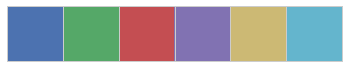

In [1]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
sns.set()
sns.set_style("whitegrid")
reso=300
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [2]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

In [11]:
df=pd.read_csv("NED28.10.1-D-15.1.0-20181130.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here
print("Galaxies in database =",len(np.unique(df['Galaxy ID'])))
print("Total measurements =",len(df)) 

df1=df[np.isfinite(df.err)&(df.err!=0)] # database of reported errors
print("Total measurements with errors =",len(df1)) 

namelist=list(df1['Galaxy ID']) # galaxy names from database of reported errors
counter=collections.Counter(namelist) # get Nmeas for each galaxy that has reported errors
meas=np.array(list(counter.values())) # convert Nmeas to np array
names=np.array(list(counter.keys())) # convert list of names to np array
df1=df1[np.in1d(df1['Galaxy ID'],names[meas>1])]
print("Galaxies with reported errors = ",len(meas))
print("Galaxies with distance measurements without reported errors = ",len(np.unique(df['Galaxy ID']))-len(meas))
print("Galaxies with reported errors with more than one measurement =",len(np.unique(df1['Galaxy ID'])) )


Galaxies in database = 178141
Total measurements = 297686
Total measurements with errors = 285079
Galaxies with reported errors =  176889
Galaxies with distance measurements without reported errors =  1252
Galaxies with reported errors with more than one measurement = 15623


### Bootstrap

In [78]:
%%time
np.random.seed(10)
nbins=5000 # 5e3 -> 2 minutes, 1e4 destroys memory
bootp50=[] # mean error from the bootstrap for each galaxy
dboot=[] # mean bootstrap distance
bootmad=[] # median absolute deviation (robust)
boot84=[]
boot16=[]
ecf=[]
eqd=[]
gal=[]
for i in names[meas>1]:
    dfilter=np.in1d(df1['Galaxy ID'],i)
    dummy=df1[dfilter]
    gal+=[i]
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
    tli=np.array(tli)
    b84=np.percentile(tli, 84,axis=0)
    b16=np.percentile(tli, 16,axis=0)
    boot84+=[np.median(b84)/1e6]
    boot16+=[np.median(b16)/1e6]
    booterr=(b84-b16)/2 # sigma draws from bootstrap for each gal
    bootmean=np.median(tli,axis=0) # mean draws from bootstrap for each gal
    bootp50+=[np.median(booterr)/1e6] # mean bootstrap error
    bootmad+=[np.median(np.abs(tli - np.median(tli)))/1e6]
    dboot+=[np.median(bootmean)/1e6] # bootstrap mean D
    wnat,avnat = weighted_std(dummy['m-M'],1/dummy['err']**2)
    distwav=10**(avnat/5+1)/1e6
    wsti=0.461*distwav*wnat # weighted standard deviation
    ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
    ecf+=[ecfi]
    eqd+=[np.sqrt(ecfi**2+wsti**2)]  

CPU times: user 3min 20s, sys: 4.8 s, total: 3min 25s
Wall time: 4min 16s


In [ ]:
d = {'Galaxy ID': names[meas>1], 'meas': meas[meas>1], 'H (Mpc)':bootp50, 'D (Mpc)':dboot,'P (Mpc)':ecf,'Q (Mpc)':eqd,'M (Mpc)':bootmad,'Dmin (Mpc)':boot16,'Dmax (Mpc)':boot84}
dfb = pd.DataFrame(data=d)
dfb.to_csv("ned_bootstrap_results.csv")

### Start here if you have bootstrap results already

In [14]:
dfb=pd.read_csv('ned_bootstrap_results.csv')

In [29]:
em=dfb.meas
dboot=dfb['D (Mpc)']
bootp50=dfb['H (Mpc)']
ecf=dfb['P (Mpc)']
eqd=dfb['Q (Mpc)']
bootmad=dfb['M (Mpc)']
boot84=dfb['Dmax (Mpc)']
boot16=dfb['Dmin (Mpc)']

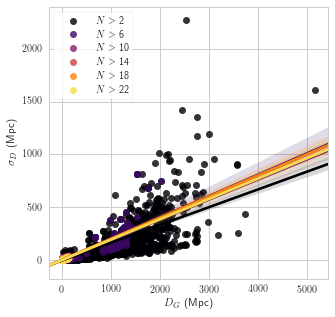

In [16]:
from matplotlib.pyplot import cm
color=cm.inferno(np.linspace(0,1,12))
plt.figure(figsize=(5,5))
for i in range(2,24,4):
    filt=(em>i)
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    sns.regplot(x,y,color=color[(i-2)//2],label='$N>$ '+str(i))
                #current_palette[(i-2)//2]) # green, quadrature 
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.savefig('mnras/relerr.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/relerr.png', dpi=reso,transparent=True)

In [17]:
filt=(em==2)
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]

(0, 1000)

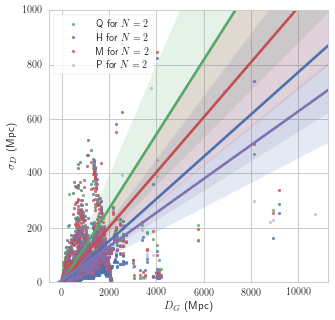

In [18]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N=2$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N=2$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N=2$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N=2$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.ylim(0,1000)

In [19]:
filt=(em<6)
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]

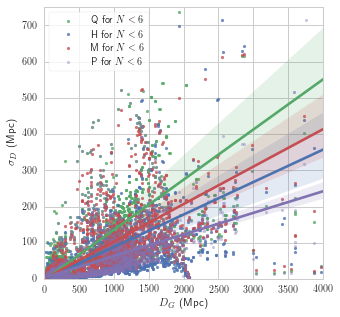

In [20]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N<6$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N<6$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N<6$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N<6$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,4000)
plt.ylim(0,750)
plt.savefig('mnras/Nlow.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/Nlow.png', dpi=reso,transparent=True)

(0, 50)

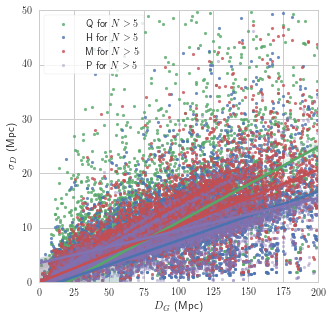

In [21]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N>5$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N>5$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N>5$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N>5$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,200)
plt.ylim(0,50)

In [22]:
filt=(em>5)
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]

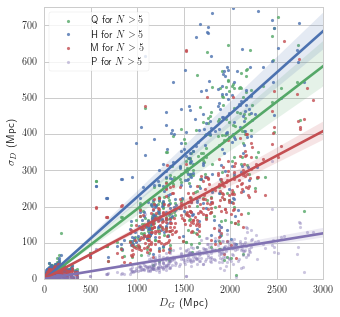

In [23]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N>5$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N>5$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N>5$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N>5$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,3000)
plt.ylim(0,750)
plt.savefig('mnras/Nhigh.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/Nhigh.png', dpi=reso,transparent=True)

(0, 100)

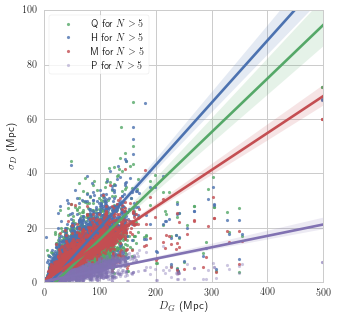

In [24]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N>5$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N>5$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N>5$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N>5$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,500)
plt.ylim(0,100)

In [30]:
x=np.array(dboot)
y8=np.array(boot84)
y1=np.array(boot16)

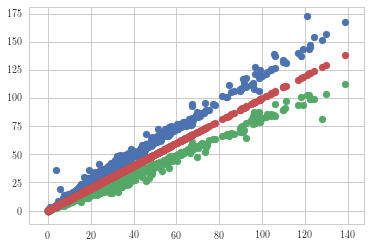

In [36]:
plt.scatter(x,y8)
plt.scatter(x,y1)
plt.scatter(x,x)

In [33]:
res=(y8-2*x+y1)/x
np.percentile(np.abs(res),95) # 95 percent of all errors are less than 15% asymmetric

0.15358219189699163

In [35]:
filt=(em>15)
x=np.array(dboot)[filt]
y8=np.array(boot84)[filt]
y1=np.array(boot16)[filt]
resabs=(y8-2*x+y1)
np.percentile(np.abs(resabs),95) # 95 percent of errors for galaxies with more than 15 measurements are less than 5 Mpc asymmetric

5.34337060546628